*This notebook was run on Colab.*

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 4.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=bf549d70944afacea926b74937f318b556286360e995b60f765687bfeada9b0e
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=5abe99860ff08bcead14533f574d707d1e55779d9bcd3e48870c761e88997c2a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
import IPython

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


# Data Ingestion

- [Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/Anomaly_Detection/S&P_500_Index_Data.csv')

In [5]:
df.head(5)

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [6]:
df.shape

(8192, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8192 non-null   object 
 1   close   8192 non-null   float64
dtypes: float64(1), object(1)
memory usage: 128.1+ KB


In [8]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

In [9]:
df.head(5)

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close))
fig.update_layout(
    title='S&P 500 Daily Prices, 1986-2018',
    xaxis_title='Date',
    yaxis_title='S&P 500 Index',
    template='plotly_white'
)

fig.show()

- **Initial observation**
  - Upward trend over time
  - Peaks at 2000 and 2007

# Data Preprocessing

## Train-test-split
- Since the time series objects are NOT independent, we will split the training and test set in sequence, using the first 90% of data as the training set and the rest as the test set.

In [11]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train, test = df.iloc[:train_size], df.iloc[train_size:]

In [12]:
print('Training set:', train.shape)
print('Test set:', test.shape)

Training set: (7372, 2)
Test set: (820, 2)


In [14]:
print('Date range for training set:')
print(min(train.date.dt.date), 'to', max(train.date.dt.date))

print('Date range for test set:')
print(min(test.date.dt.date), 'to', max(test.date.dt.date))

Date range for training set:
1986-01-02 to 2015-03-30
Date range for test set:
2015-03-31 to 2018-06-29


## Standardizing

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

# Temporalizing data for train-test-split

In [16]:
def get_sequences(X, y, time_steps=30):
  X_seq, y_seq = [], []

  for i in range(len(X) - time_steps):
    X_seq.append(X.iloc[i:(i + time_steps)].values)
    y_seq.append(y.iloc[i + time_steps])

  return np.array(X_seq), np.array(y_seq)

In [17]:
X_train, y_train = get_sequences(train[['close']], train.close)
X_test, y_test = get_sequences(test[['close']], test.close)

In [18]:
print('Training set:', X_train.shape)
print('Test set:', X_test.shape)

Training set: (7342, 30, 1)
Test set: (790, 30, 1)


# Model: LSTM Autoencoder

## Baseline

In [19]:
TIME_STEPS = X_train.shape[1]
N_FEATURES = X_train.shape[2]

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

baseline = Sequential([
                       LSTM(32, input_shape=(TIME_STEPS, N_FEATURES)),
                       Dropout(0.2),
                       RepeatVector(TIME_STEPS),
                       LSTM(32, return_sequences=True),
                       Dropout(0.2),
                       TimeDistributed(Dense(N_FEATURES))   
])

In [21]:
baseline.compile(loss='mae', optimizer='adam')
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
____________________________________________________

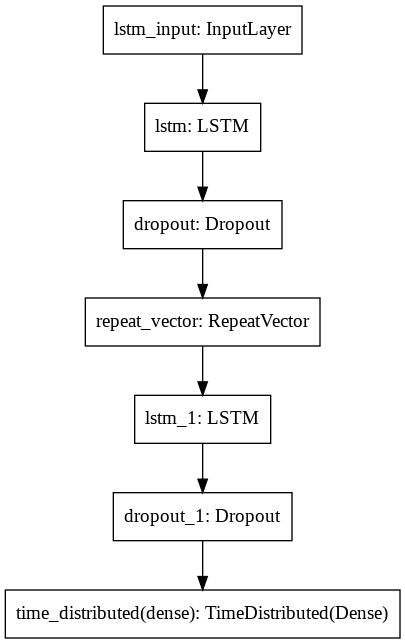

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(baseline, to_file='baseline.png')

### Training
- Early stopping: no improvement in validation loss in three epochs

In [23]:
MAX_EPOCHS = 50
BATCH_SIZE = 32

In [24]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

baseline_history = baseline.fit(
    X_train, y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/50
207/207 [==============================] - 7s 32ms/step - loss: 0.2143 - val_loss: 0.5783
Epoch 2/50
207/207 [==============================] - 6s 29ms/step - loss: 0.1418 - val_loss: 0.3576
Epoch 3/50
207/207 [==============================] - 6s 29ms/step - loss: 0.1132 - val_loss: 0.3962
Epoch 4/50
207/207 [==============================] - 6s 29ms/step - loss: 0.1119 - val_loss: 0.4062
Epoch 5/50
207/207 [==============================] - 6s 29ms/step - loss: 0.1175 - val_loss: 0.4155


### Evaluation

In [25]:
def plot_history(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.title('Training and Validation Loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

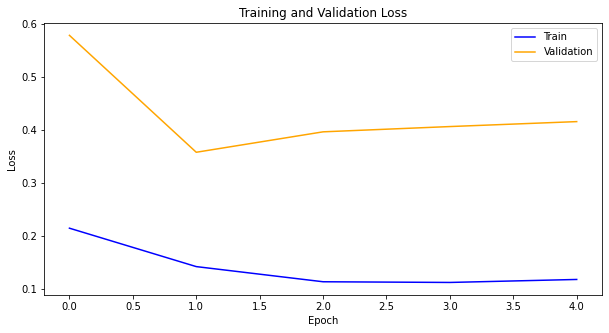

In [26]:
plot_history(baseline_history)

In [27]:
baseline.evaluate(X_test, y_test)

25/25 [==============================] - 0s 7ms/step - loss: 1.3107


1.310660719871521

- Sign of underfitting: flat curve of the training loss

## Tuning model: Hyperband

### Training

In [29]:
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def build(self, hp):
        model = Sequential()
        units = hp.Choice(
            'lstm_units',
            values=[64, 128])
        model.add(LSTM(units, input_shape=self.input_shape))
        rate = hp.Float(
            'dropout',
            min_value=0.1,
            max_value=0.5,
            default=0.2,
            step=0.1)
        model.add(Dropout(rate=rate))
        model.add(RepeatVector(TIME_STEPS))
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(rate=rate))
        model.add(TimeDistributed(Dense(self.output_shape)))

        model.compile(
            optimizer=Adam(learning_rate=
                hp.Choice(
                    'learning_rate',
                    values=[1e-3, 1e-2],
                    default=1e-2)
            ),
            loss='mae'
            )

        return model

In [30]:
hypermodel = LSTMHyperModel(input_shape=(TIME_STEPS, N_FEATURES),
                            output_shape=N_FEATURES)

In [31]:
HYPERBAND_MAX_EPOCHS = 20 # max number of epochs a model can be trained for
EXECUTION_PER_TRIAL = 2 # number of models that should be built and fit 
# for each trial for robustness purposes

In [31]:
# !rm -rfv /content/anomaly_detection/

In [32]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    project_name = 'anomaly_detection'
)

In [33]:
tuner.search_space_summary()

In [34]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  """Reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
     Clears the training outputs at the end of every training step.  
  """
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [35]:
tuner.search(X_train, 
             y_train, 
             epochs=HYPERBAND_MAX_EPOCHS, 
             batch_size=BATCH_SIZE,
             validation_split=0.1,
             callbacks=[ClearTrainingOutput()],
             shuffle=False)

INFO:tensorflow:Oracle triggered exit


In [36]:
# tuner.results_summary()

In [36]:
best_hps = tuner.get_best_hyperparameters()[0]

In [37]:
print(f"""
The hyperparameter search is complete. 
The optimal number of units in the LSTM layer is {best_hps.get('lstm_units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the LSTM layer is 128.
The optimal dropout rate is 0.30000000000000004.
The optimal learning rate for the optimizer is 0.001.



In [38]:
best_model = tuner.hypermodel.build(best_hps)

In [39]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

best_history = best_model.fit(
    X_train, y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/50
207/207 [==============================] - 16s 77ms/step - loss: 0.1520 - val_loss: 0.2968
Epoch 2/50
207/207 [==============================] - 15s 74ms/step - loss: 0.1033 - val_loss: 0.0837
Epoch 3/50
207/207 [==============================] - 15s 74ms/step - loss: 0.0806 - val_loss: 0.0789
Epoch 4/50
207/207 [==============================] - 15s 74ms/step - loss: 0.0890 - val_loss: 0.0738
Epoch 5/50
207/207 [==============================] - 15s 75ms/step - loss: 0.0903 - val_loss: 0.0617
Epoch 6/50
207/207 [==============================] - 15s 74ms/step - loss: 0.0819 - val_loss: 0.1107
Epoch 7/50
207/207 [==============================] - 15s 74ms/step - loss: 0.0853 - val_loss: 0.1331
Epoch 8/50
207/207 [==============================] - 15s 74ms/step - loss: 0.0962 - val_loss: 0.1688


### Evaluation

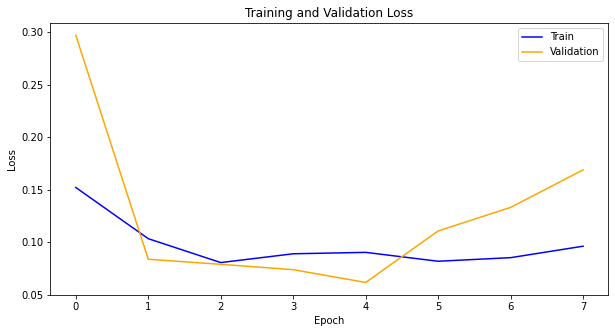

In [40]:
plot_history(best_history)

In [41]:
best_model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 22ms/step - loss: 0.4089


0.40888550877571106

# Detecting Anomalies

## Setting threshold

- A data point is identified as anomaly if its test loss exceeds the threshold. 
- To determine a threshold, we look at the distribution of training loss (MAE).

In [42]:
X_train_pred = best_model.predict(X_train)
train_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1),
                          columns=['loss'])

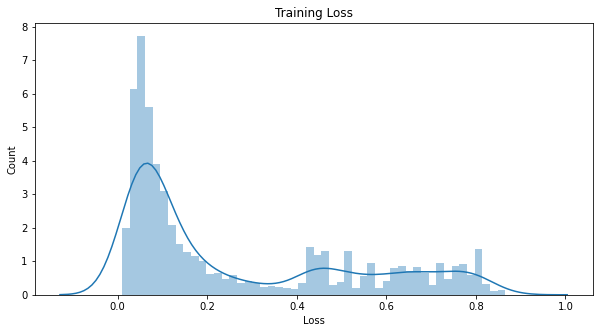

In [43]:
_ = plt.figure(figsize=(10, 5))
_ = sns.distplot(train_loss, bins=50, kde=True)
_ = plt.title('Training Loss')
_ = plt.xlabel('Loss')
_ = plt.ylabel('Count')

In [44]:
train_loss.describe()

,loss
count,7342.000000
mean,0.262154
std,0.258464
min,0.009363
25%,0.057453
50%,0.117479
75%,0.460516
max,0.865391


In [60]:
np.percentile(train_loss, 90)

0.7030770037884082

- We will set the threshold to be 0.7 which captures roughly 90% of the training loss.

In [61]:
THRESHOLD = 0.7

## Anomalies in test set

In [46]:
X_test_pred = best_model.predict(X_test)
test_loss = pd.DataFrame(np.mean(np.abs(X_test_pred - X_test), axis=1),
                         columns=['loss'])

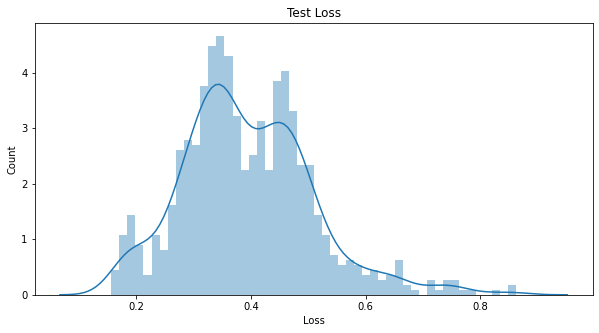

In [47]:
_ = plt.figure(figsize=(10, 5))
_ = sns.distplot(test_loss, bins=50, kde=True)
_ = plt.title('Test Loss')
_ = plt.xlabel('Loss')
_ = plt.ylabel('Count')

In [62]:
test_score = pd.DataFrame(test[TIME_STEPS:])
test_score['loss'] = test_loss.values
test_score['is_anomaly'] = test_score.loss > THRESHOLD

In [63]:
test_score.head(5)

,date,close,loss,is_anomaly
7402,2015-05-13,2.418612,0.322199,False
7403,2015-05-14,2.465645,0.327835,False
7404,2015-05-15,2.469034,0.313360,False
7405,2015-05-18,2.482487,0.304506,False
7406,2015-05-19,2.479639,0.297218,False


In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score.date, 
                         y=test_score.loss, 
                         name='Test loss'))
fig.add_trace(go.Scatter(x=test_score.date, 
                         y=np.repeat(THRESHOLD, len(test_score.date)),
                         name='Threshold',
                         line=dict(color='orange', width=2, dash='dot')))

fig.update_layout(
    title='Test Loss',
    xaxis_title='Date',
    yaxis_title='Loss',
    template='plotly_white'
)

fig.show()

In [65]:
anomalies = test_score[test_score['is_anomaly']]

In [66]:
print('Number of anomalies:', len(anomalies))

Number of anomalies: 15


In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score.date, 
                         y=scaler.inverse_transform(test_score.close),
                         name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, 
                         y=scaler.inverse_transform(anomalies.close),
                         mode='markers',
                         marker=dict(size=5),
                         name='Anomalies'))

fig.update_layout(
    title='Anomalies in Test Data',
    xaxis_title='Date',
    yaxis_title='Close Price',
    template='plotly_white'
)

fig.show()